# Scanpy: Differential expression

Once we have done clustering, let's compute a ranking for the highly differential genes in each cluster. 


Differential expression is performed with the function `rank_genes_group`.  The default method to compute differential expression is the `t-test_overestim_var`. Other implemented methods are: `logreg`, `t-test` and `wilcoxon`.

By default, the .raw attribute of AnnData is used in case it has been initialized, it can be changed by setting `use_raw=False`. 

The clustering with resolution 0.6 seems to give a reasonable number of clusters, so we will use that clustering for all DE tests.

First, let's import libraries and fetch the clustered data from the previous lab.

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt

sc.settings.verbosity = 2             # verbosity: errors (0), warnings (1), info (2), hints (3)
#sc.logging.print_versions()


In [2]:
sc.settings.set_figure_params(dpi=80)

Read in the clustered data object.

In [3]:
adata = sc.read_h5ad('./data/results/scanpy_clustered_covid.h5ad')

In [4]:
print(adata.shape)
print(adata.raw.shape)

(5594, 3067)
(5594, 18752)


### T-test 

ranking genes
    finished (0:00:01)


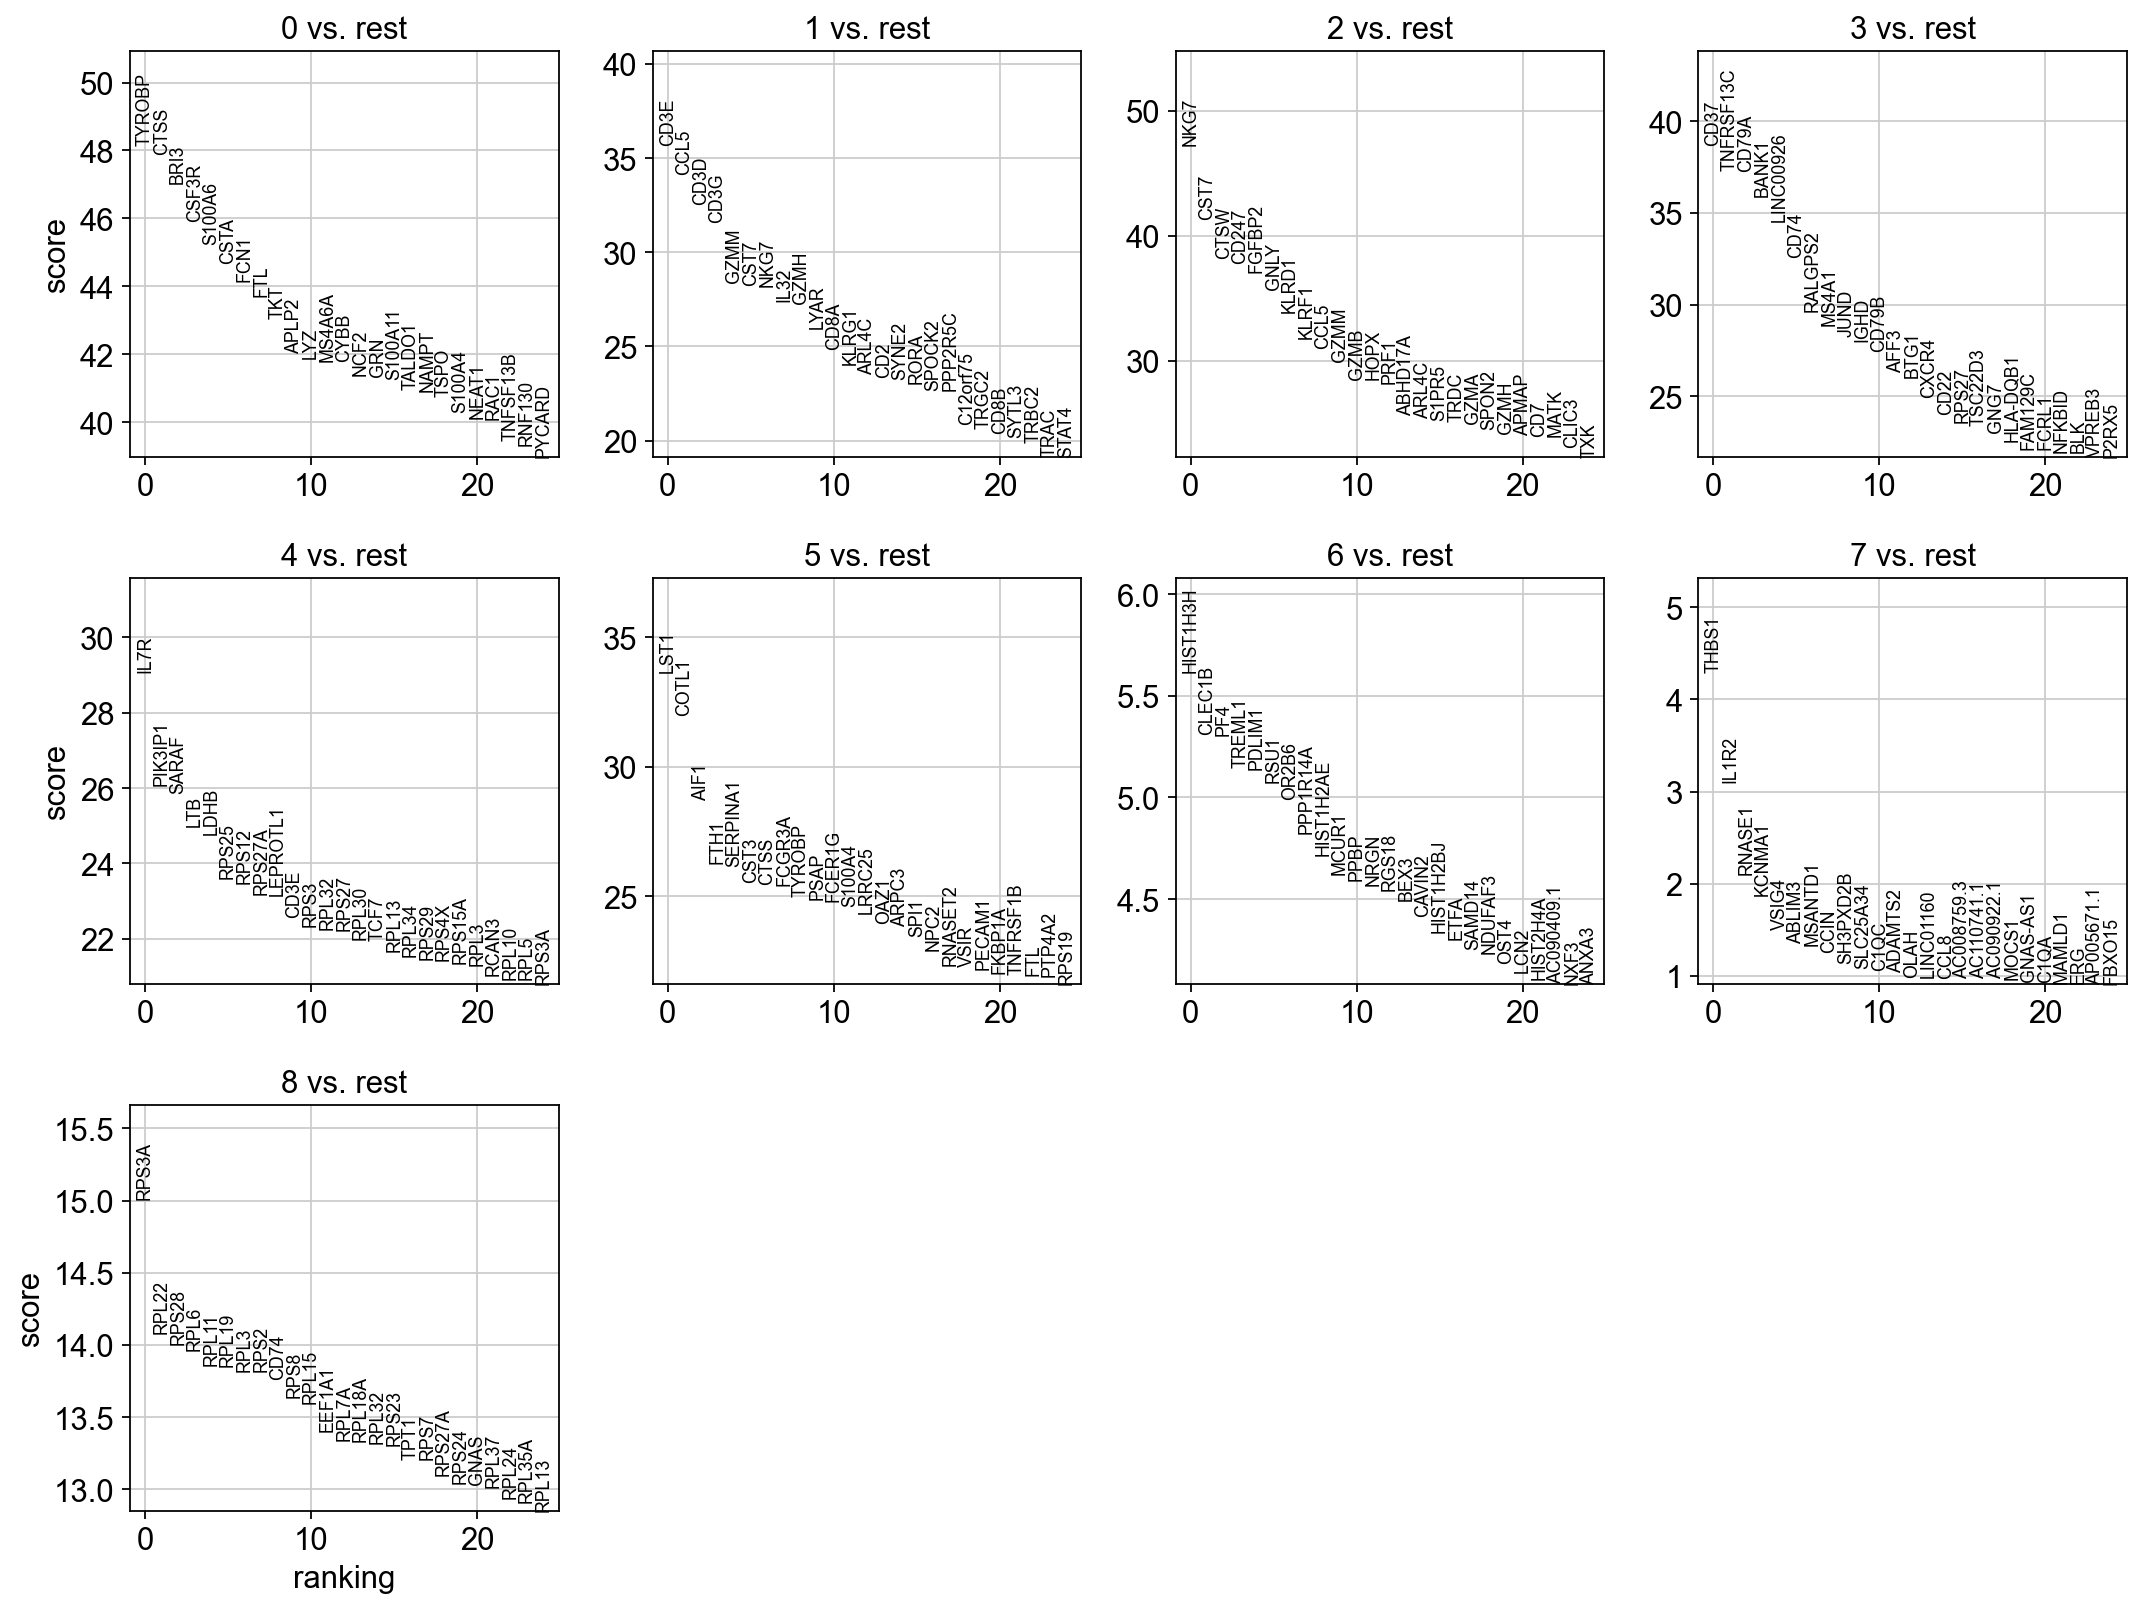

In [5]:
sc.tl.rank_genes_groups(adata, 'louvain_0.6', method='t-test', key_added = "t-test")
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False, key = "t-test")


In [6]:
# results are stored in the adata.uns["t-test"] slot
adata

AnnData object with n_obs × n_vars = 5594 × 3067
    obs: 'type', 'sample', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'percent_mt2', 'n_counts', 'n_genes', 'S_score', 'G2M_score', 'phase', 'doublet_scores', 'predicted_doublets', 'doublet_info', 'leiden_1.0', 'leiden_0.6', 'leiden_0.4', 'leiden_1.4', 'louvain_1.0', 'louvain_0.6', 'louvain_0.4', 'louvain_1.4', 'kmeans5', 'kmeans10', 'kmeans15', 'hclust_5', 'hclust_10', 'hclust_15'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: "dendrogram_['leiden_0.6']", "dendrogram_['louvain_0.6']", 'dendrogram_leiden_0.6', 'dendrogram_louvain_0.6', 'doublet_info_colors', 'hclust_10_colors', 'hclust_15_colors', 'hclust_5_colors', 'hvg', 'kmeans10_

### T-test overestimated_variance

ranking genes
    finished (0:00:01)


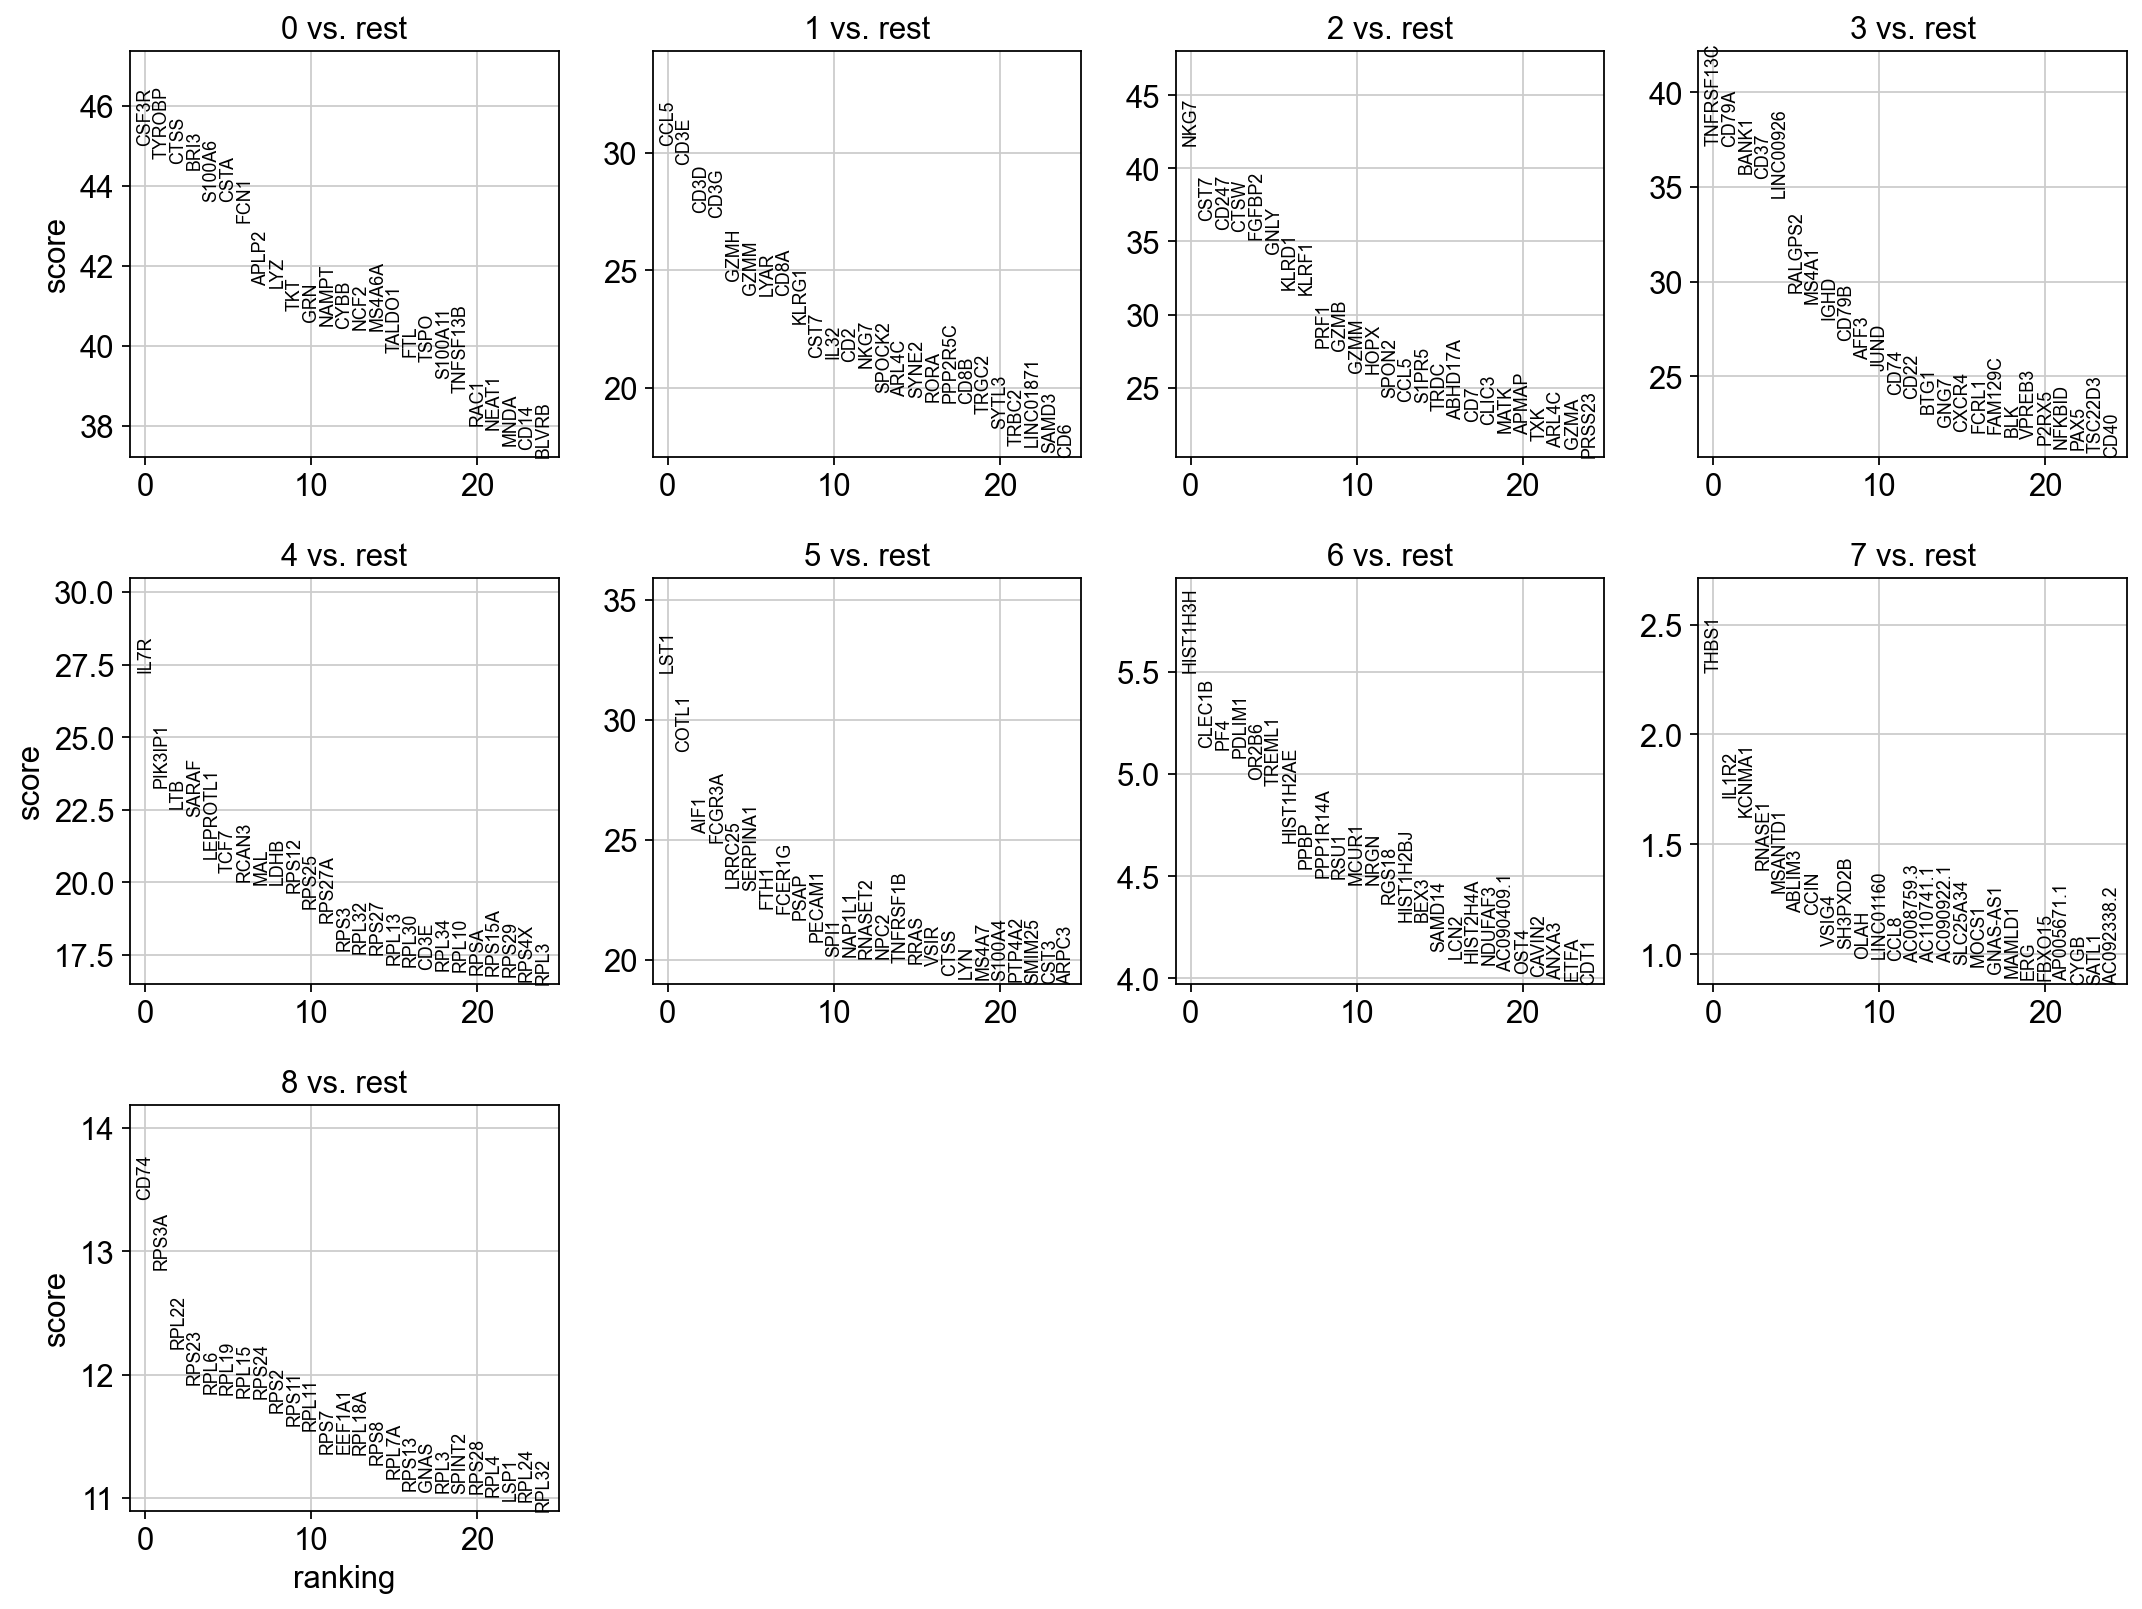

In [7]:
sc.tl.rank_genes_groups(adata, 'louvain_0.6', method='t-test_overestim_var', key_added = "t-test_ov")
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False, key = "t-test_ov")


### Wilcoxon rank-sum

The result of a [Wilcoxon rank-sum (Mann-Whitney-U)](https://de.wikipedia.org/wiki/Wilcoxon-Mann-Whitney-Test) test is very similar. We recommend using the latter in publications, see e.g., [Sonison & Robinson (2018)](https://doi.org/10.1038/nmeth.4612). You might also consider much more powerful differential testing packages like MAST, limma, DESeq2 and, for python, the recent diffxpy.

ranking genes
    finished (0:00:08)


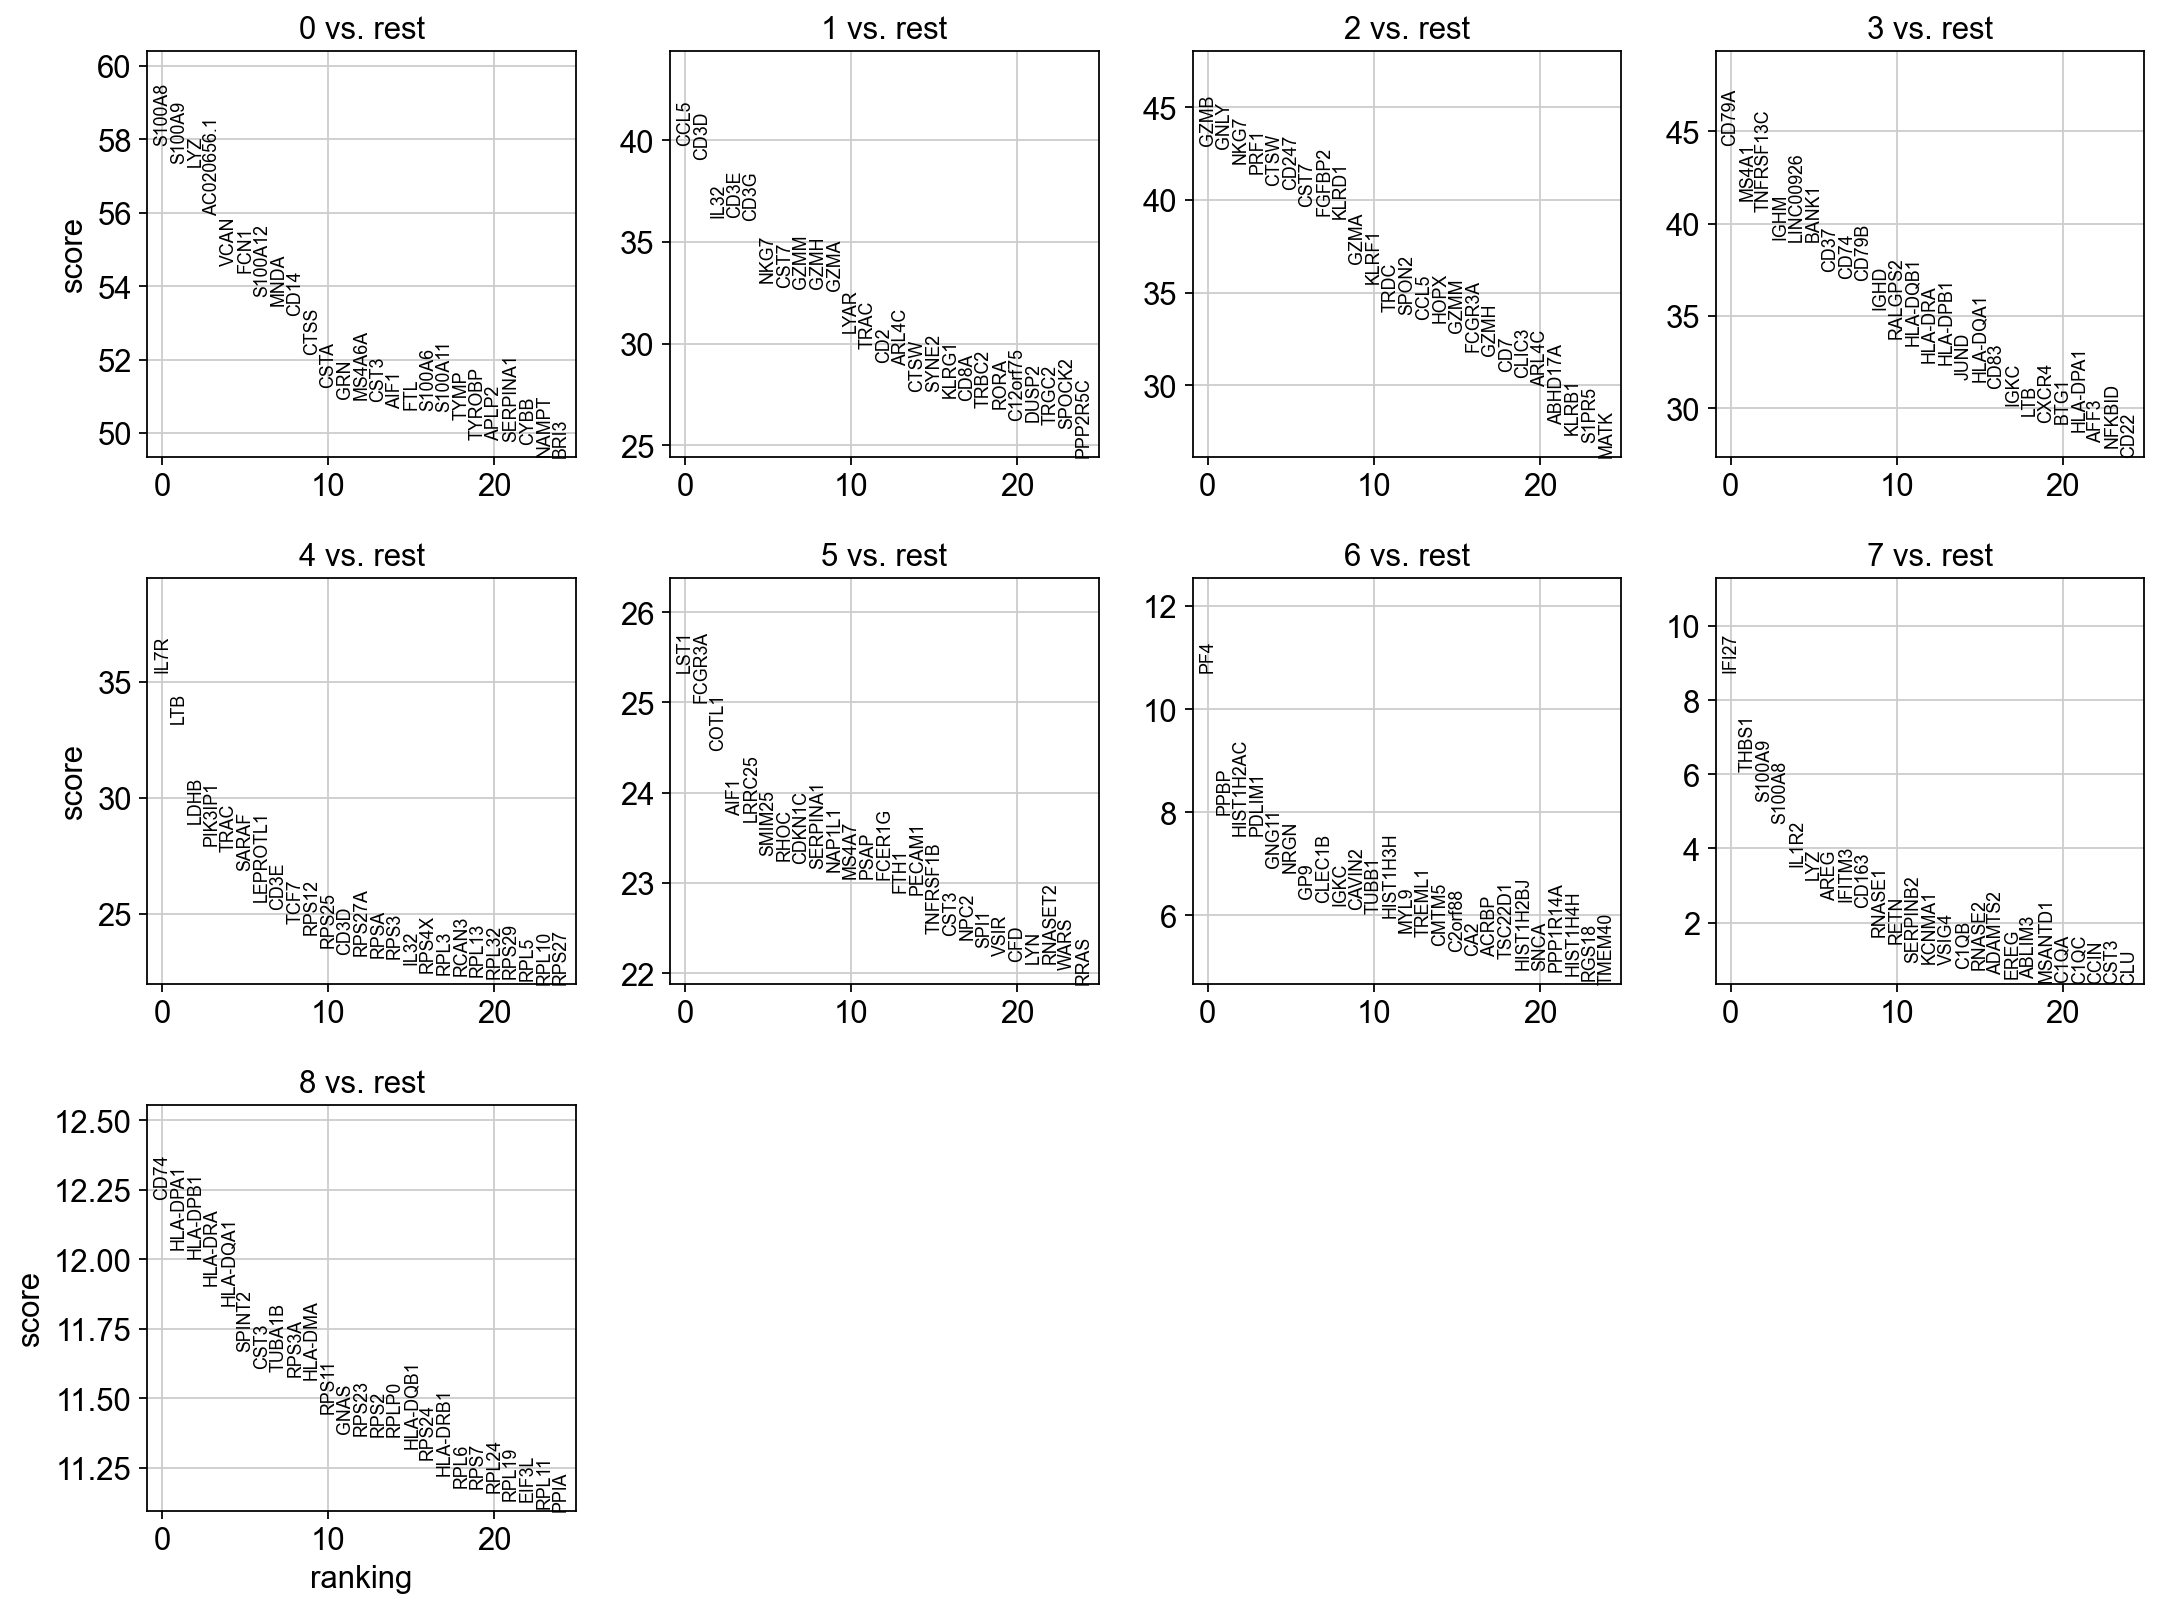

In [8]:
sc.tl.rank_genes_groups(adata, 'louvain_0.6', method='wilcoxon', key_added = "wilcoxon")
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False, key="wilcoxon")

### Logistic regression test

As an alternative, let us rank genes using logistic regression. For instance, this has been suggested by [Natranos et al. (2018)](https://doi.org/10.1101/258566). The essential difference is that here, we use a multi-variate appraoch whereas conventional differential tests are uni-variate. [Clark et al. (2014)](https://doi.org/10.1186/1471-2105-15-79) has more details.

ranking genes
    finished (0:00:29)


/Users/asbj/miniconda3/envs/scRNAseq2021/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


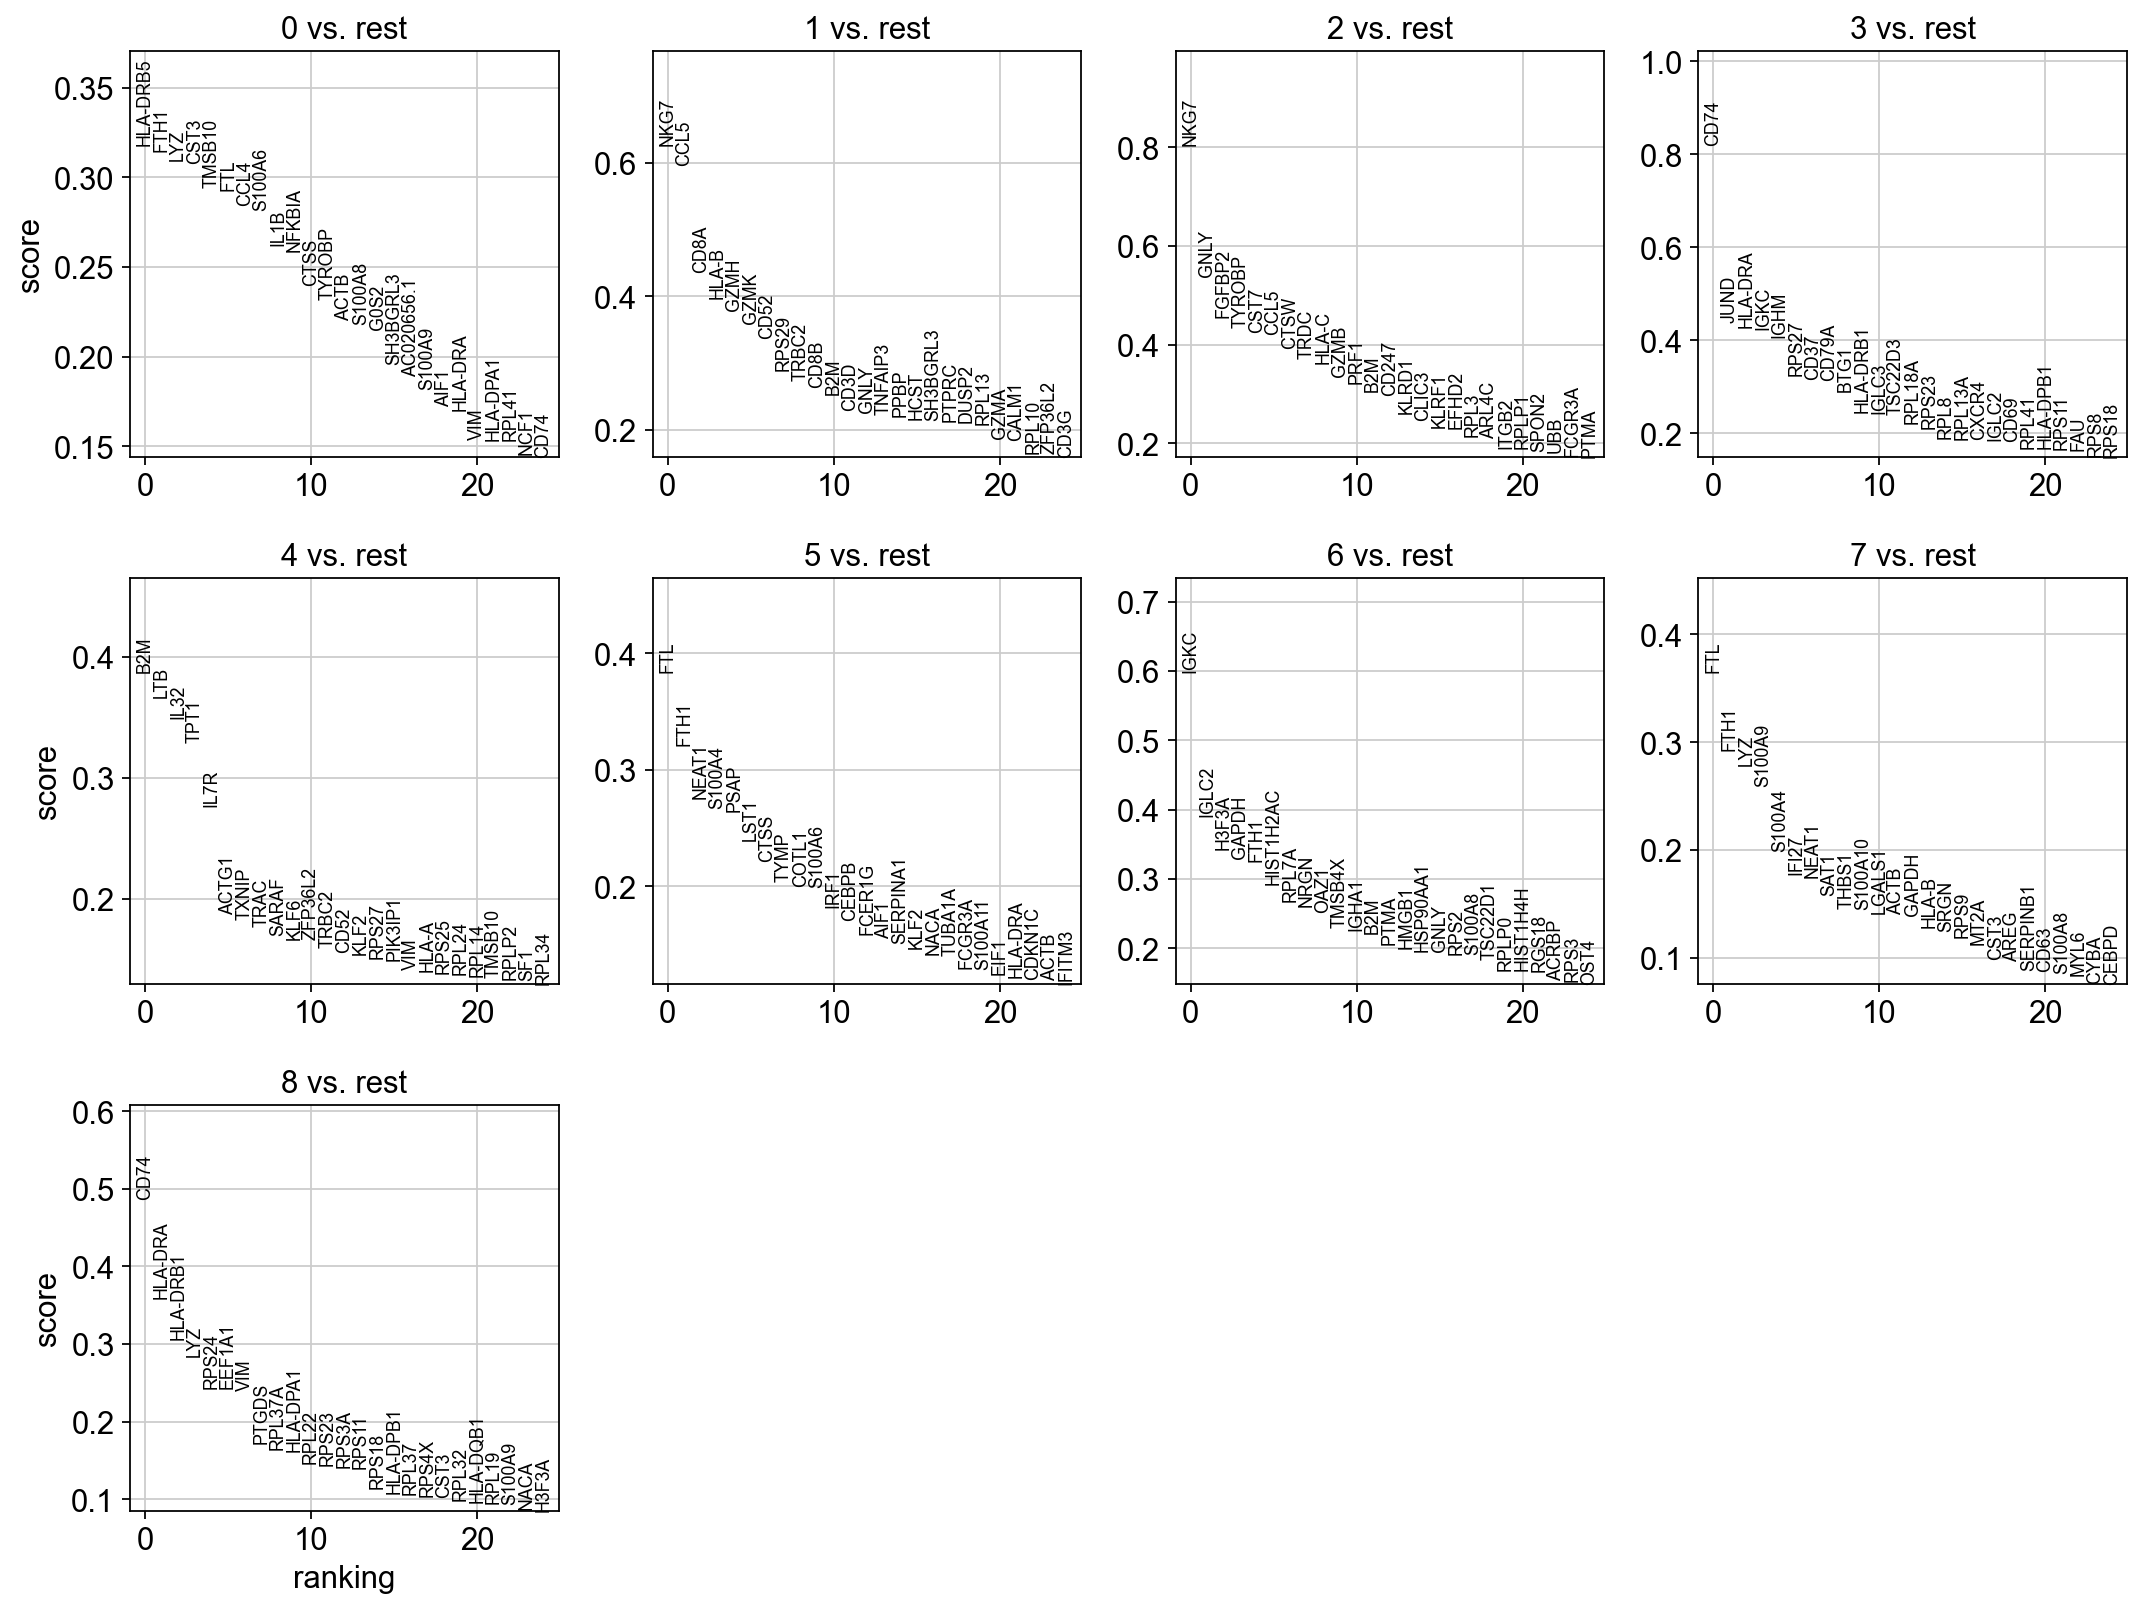

In [9]:
sc.tl.rank_genes_groups(adata, 'louvain_0.6', method='logreg',key_added = "logreg")
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False, key = "logreg")

###Compare genes

Take all significant DE genes for cluster0 with each test and compare the overlap.

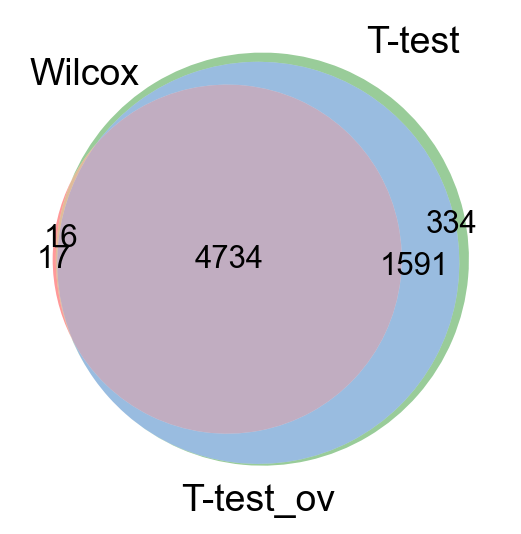

In [10]:
#compare cluster1 genes, only stores top 100 by default

wc = sc.get.rank_genes_groups_df(adata, group='0', key='wilcoxon', pval_cutoff=0.01, log2fc_min=0)['names']
tt = sc.get.rank_genes_groups_df(adata, group='0', key='t-test', pval_cutoff=0.01, log2fc_min=0)['names']
tt_ov = sc.get.rank_genes_groups_df(adata, group='0', key='t-test_ov', pval_cutoff=0.01, log2fc_min=0)['names']

from matplotlib_venn import venn3

venn3([set(wc),set(tt),set(tt_ov)], ('Wilcox','T-test','T-test_ov') )
plt.show()



As you can see, the Wilcoxon test and the T-test with overestimated variance gives very similar result. Also the regular T-test has good overlap, while the Logistic regression gives quite different genes.

### Visualization

There are several ways to visualize the expression of top DE genes. Here we will plot top 5 genes per cluster from Wilcoxon test as heatmap, dotplot, violin plot or matrix.

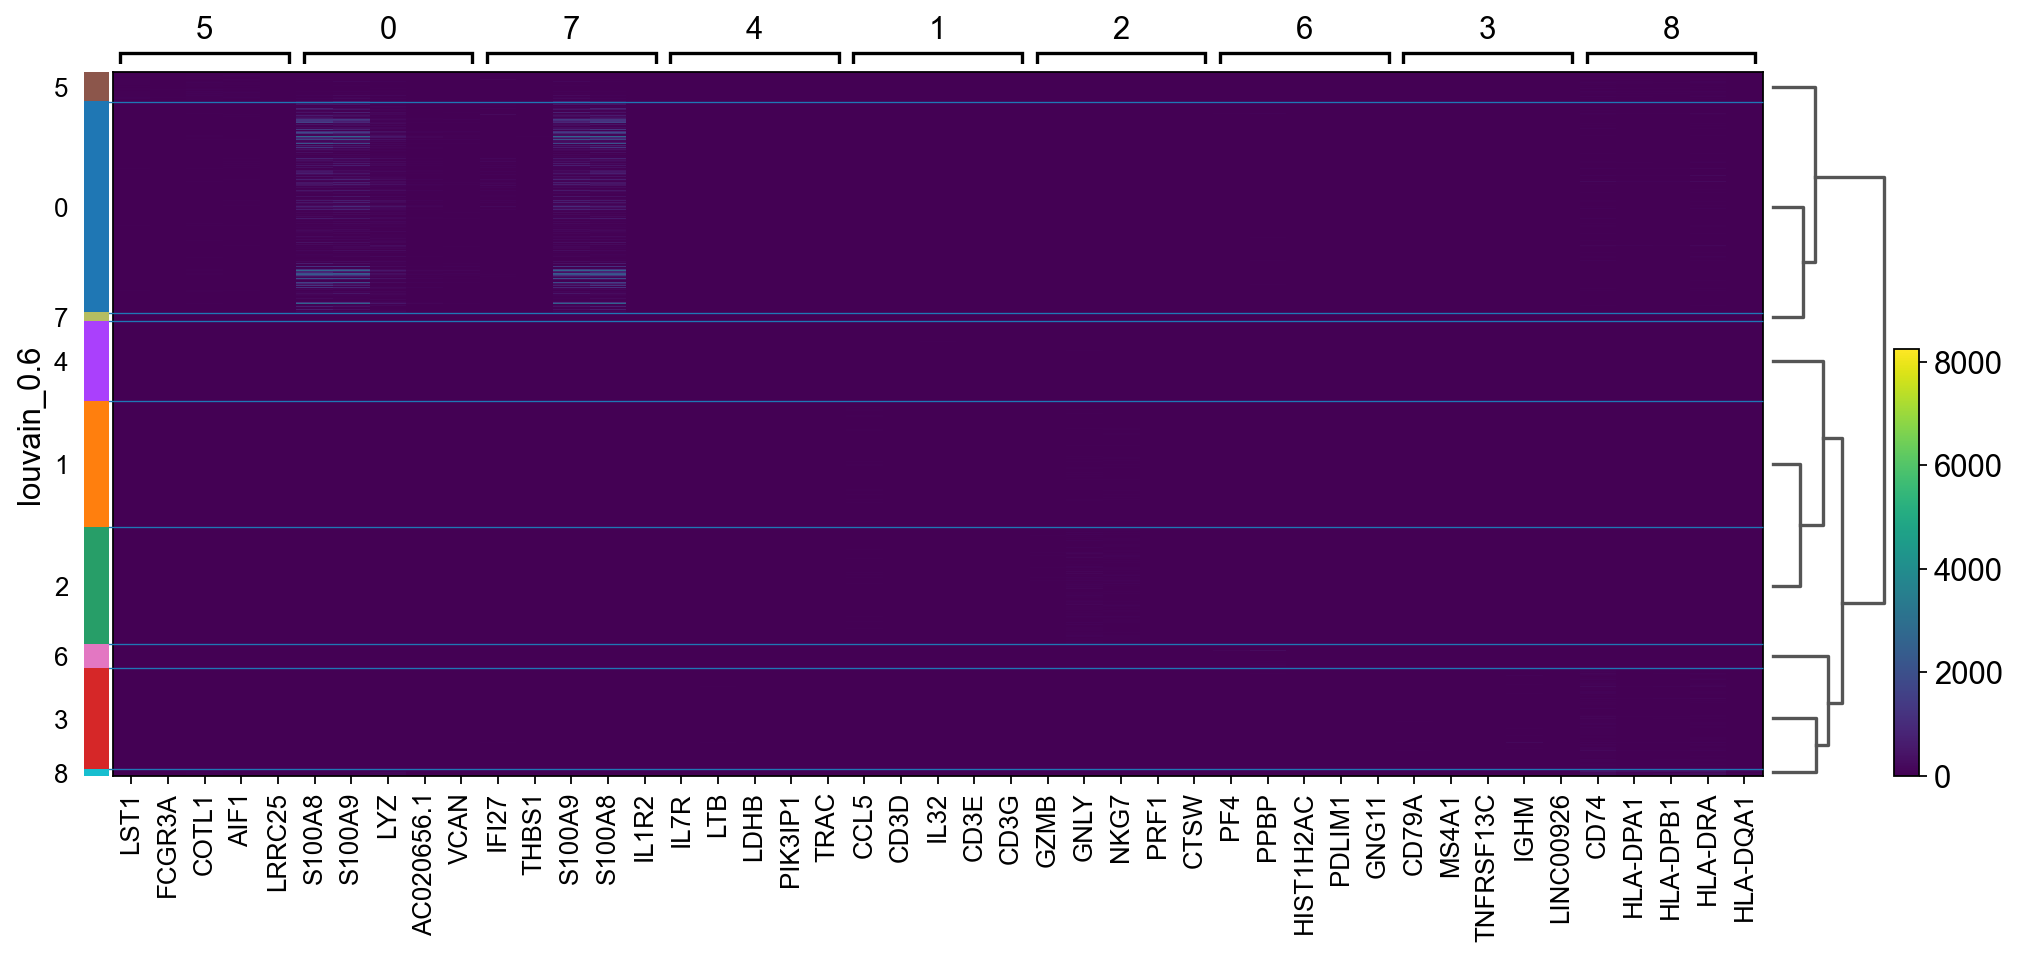

In [11]:
sc.pl.rank_genes_groups_heatmap(adata, n_genes=5, key="wilcoxon", groupby="louvain_0.6", show_gene_labels=True)

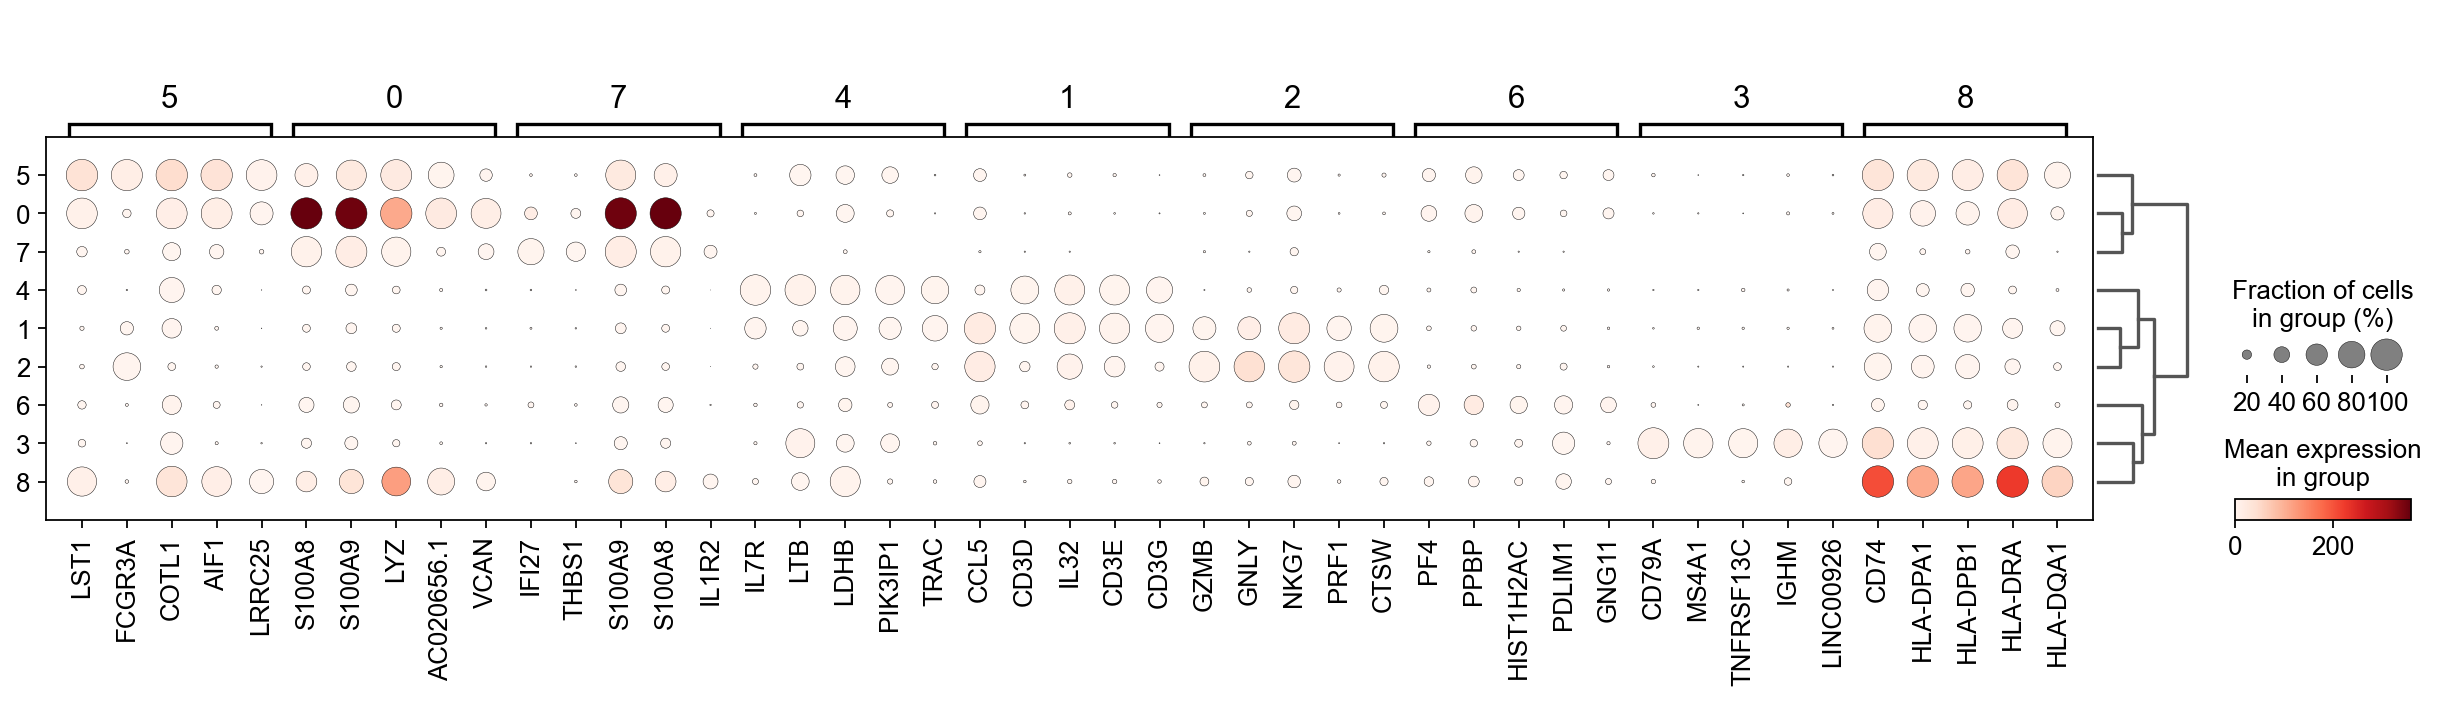

In [12]:
sc.pl.rank_genes_groups_dotplot(adata, n_genes=5, key="wilcoxon", groupby="louvain_0.6")

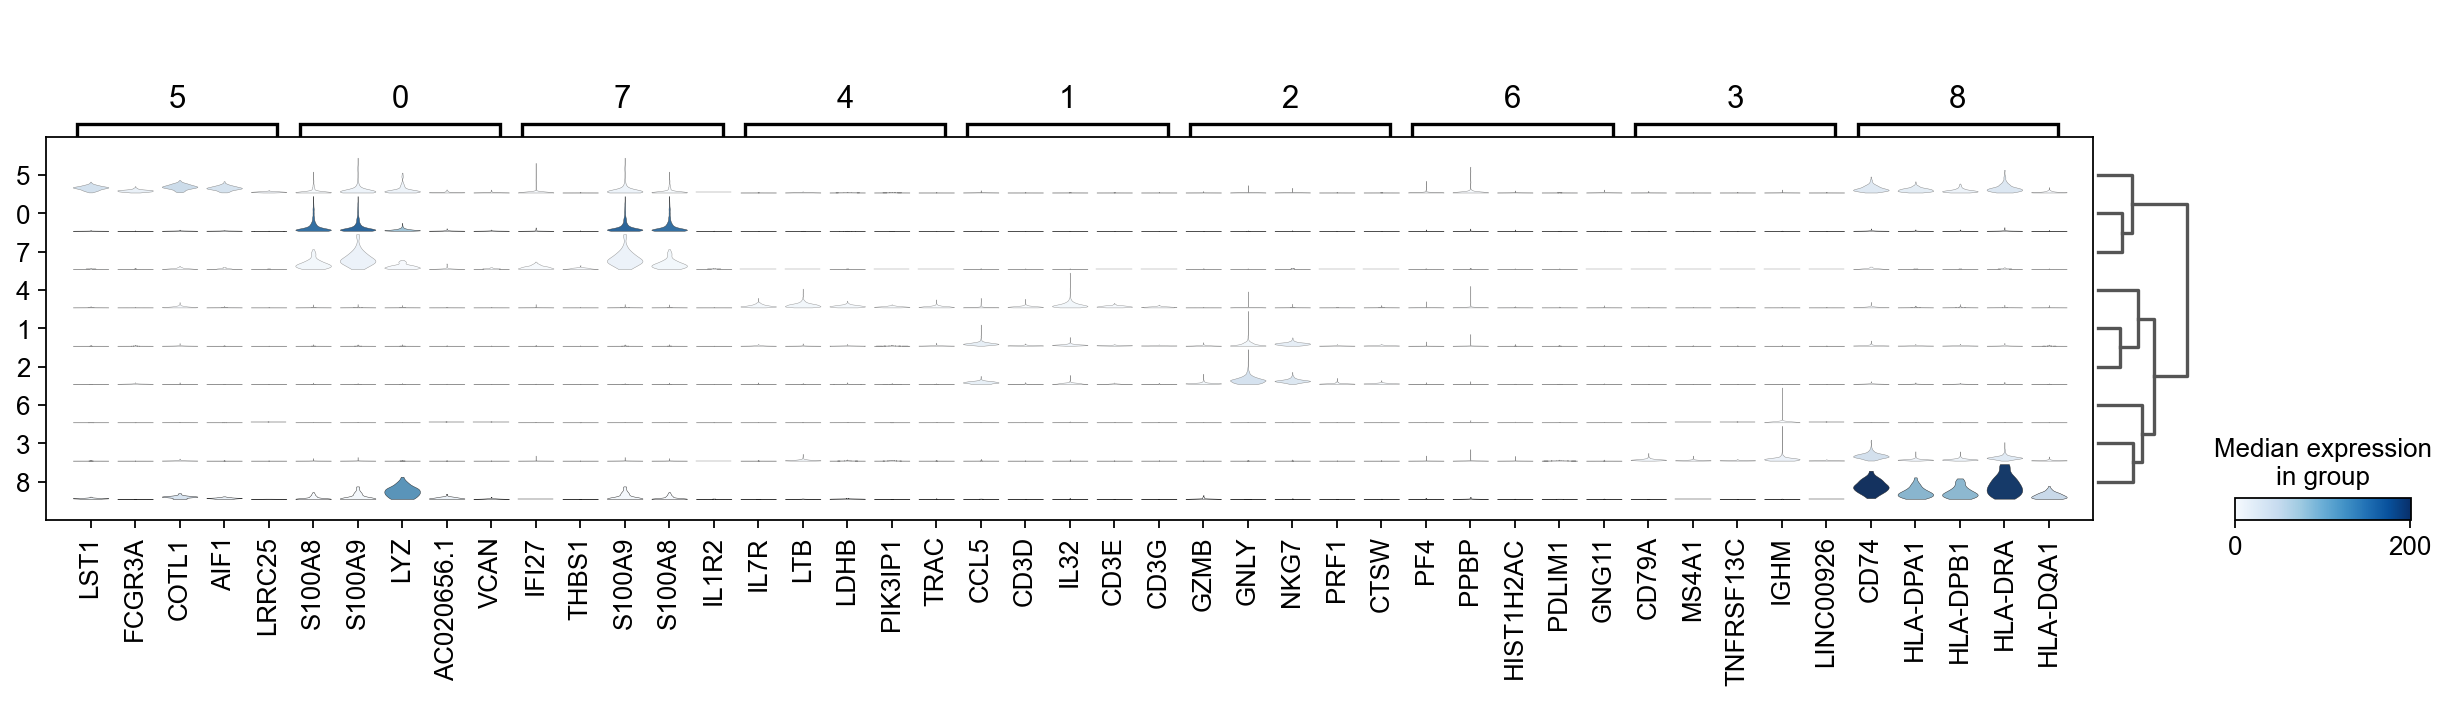

In [13]:
sc.pl.rank_genes_groups_stacked_violin(adata, n_genes=5, key="wilcoxon", groupby="louvain_0.6")

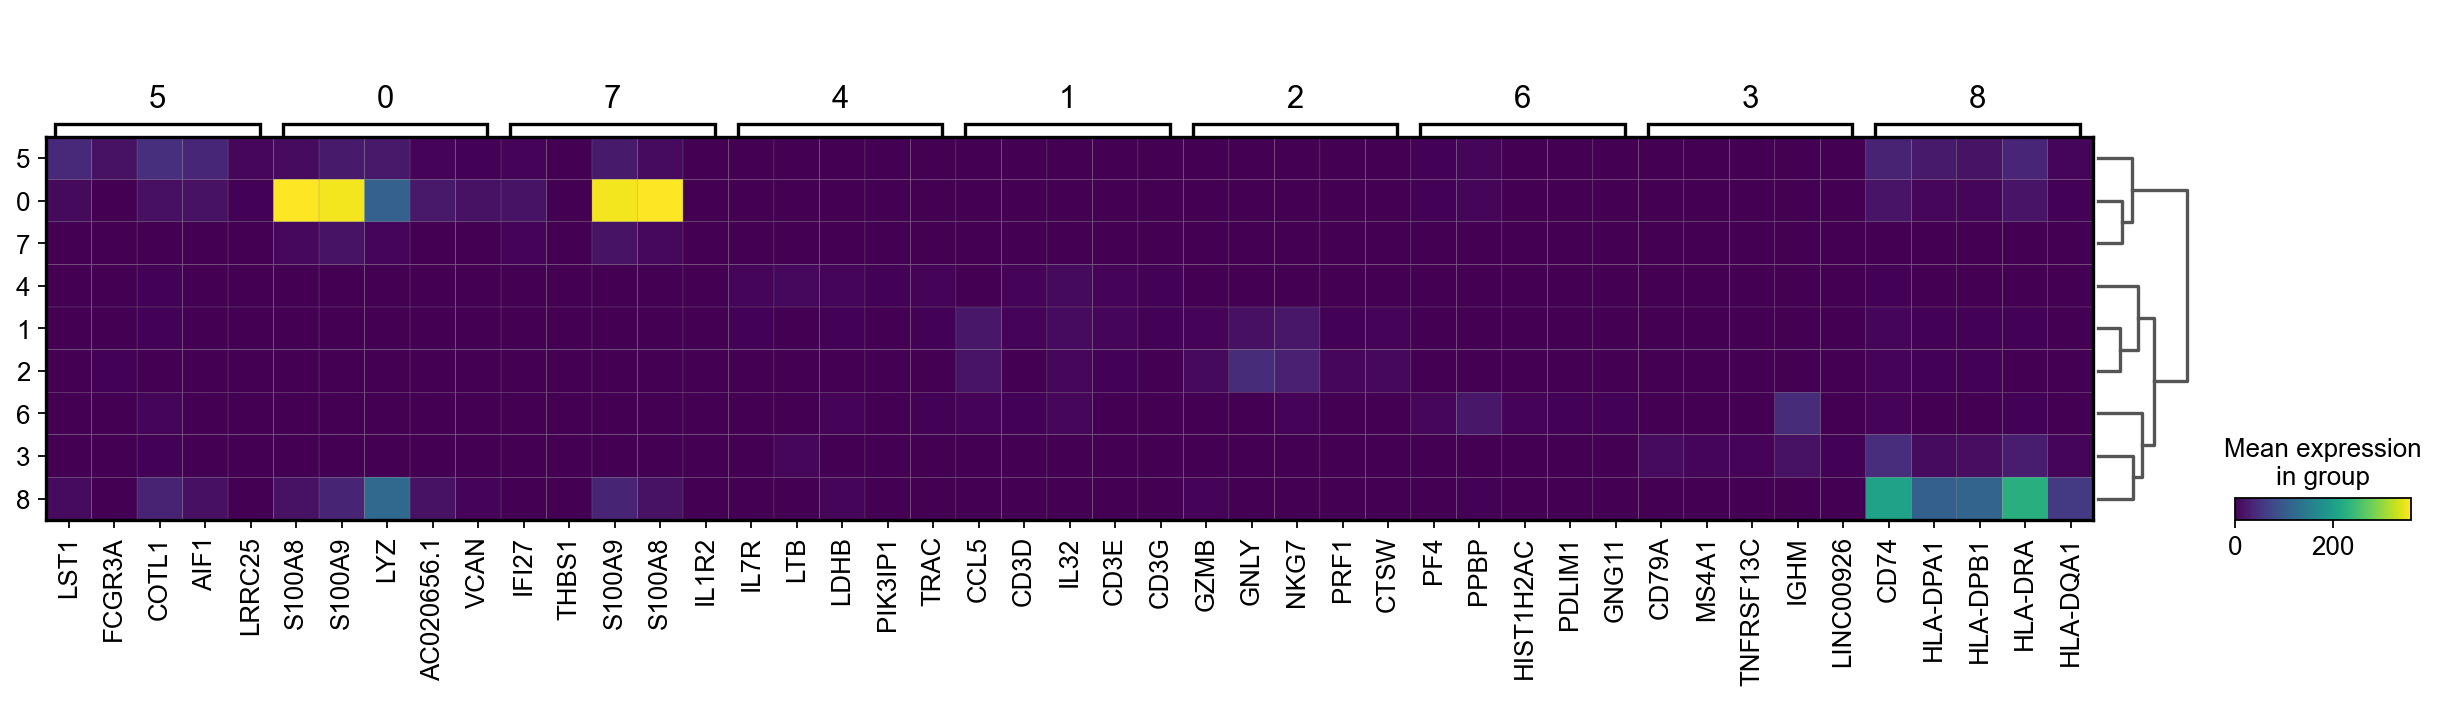

In [14]:
sc.pl.rank_genes_groups_matrixplot(adata, n_genes=5, key="wilcoxon", groupby="louvain_0.6")

### Compare specific clusters

We can also do pairwise comparisons of individual clusters on one vs many clusters. 

For instance, clusters 1 & 2 have very similar expression profiles.

ranking genes
    finished (0:00:02)


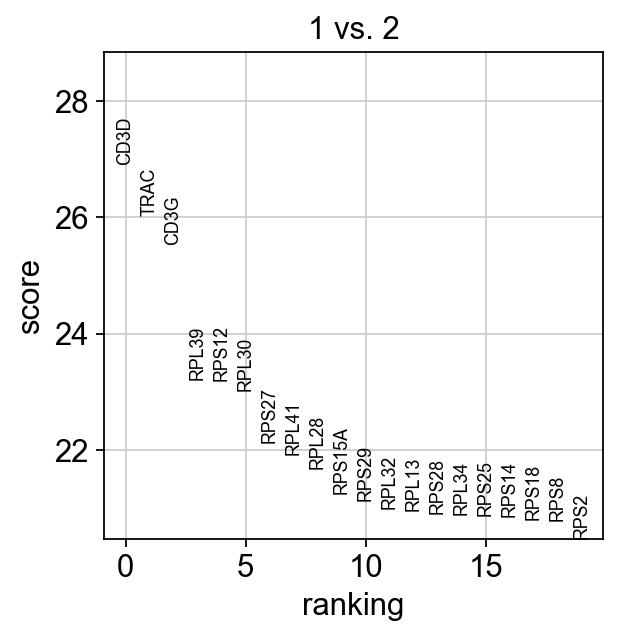

In [15]:
sc.tl.rank_genes_groups(adata, 'louvain_0.6', groups=['1'], reference='2', method='wilcoxon')
sc.pl.rank_genes_groups(adata, groups=['1'], n_genes=20)

Plot as violins for those two groups.

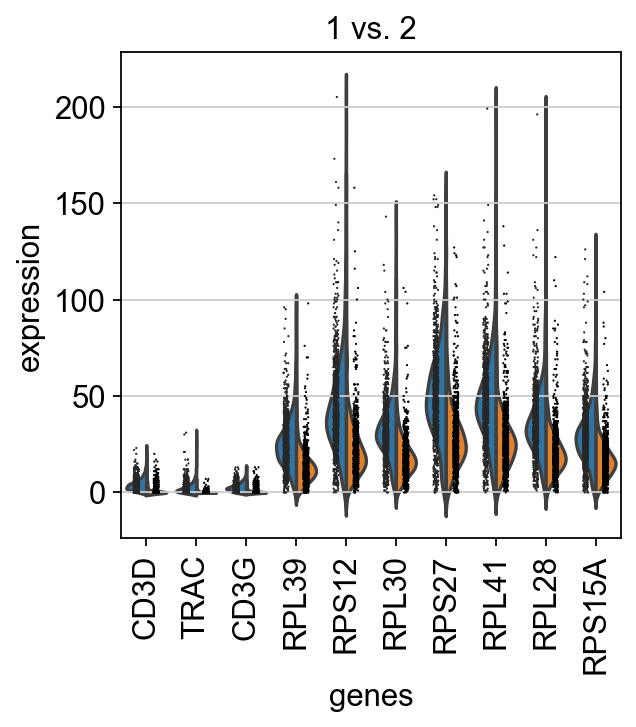

In [16]:
sc.pl.rank_genes_groups_violin(adata, groups='1', n_genes=10)


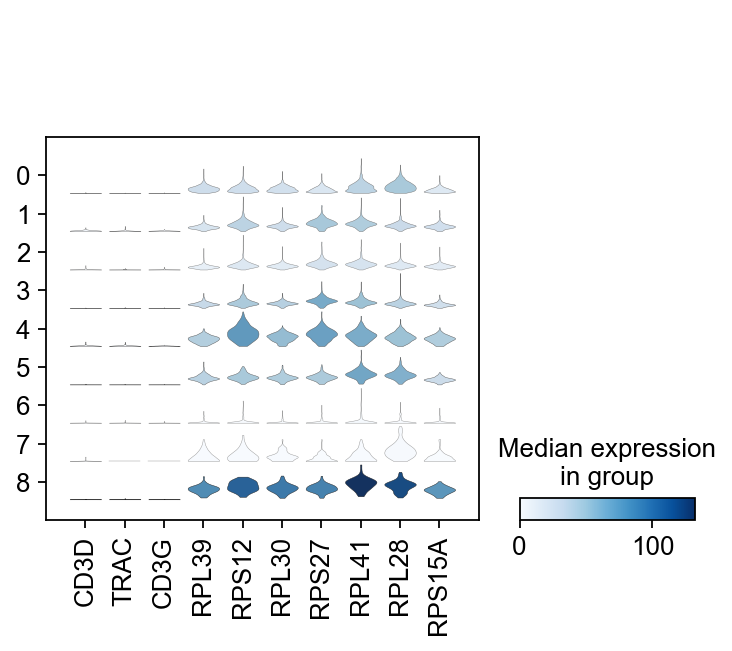

In [17]:
# plot the same genes as violins across all the datasets.

# convert numpy.recarray to list
mynames = [x[0] for x in adata.uns['rank_genes_groups']['names'][:10]]
sc.pl.stacked_violin(adata, mynames, groupby = 'louvain_0.6')


## Differential expression across conditions
***

The second way of computing differential expression is to answer which genes are differentially expressed within a cluster. For example, in our case we have libraries comming from patients and controls and we would like to know which genes are influenced the most in a particular cell type. 

For this end, we will first subset our data for the desired cell cluster, then change the cell identities to the variable of comparison (which now in our case is the "type", e.g. Covid/Ctrl).


In [18]:
cl1 = adata[adata.obs['louvain_0.6'] == '1',:]
cl1.obs['type'].value_counts()

Ctrl     693
Covid    305
Name: type, dtype: int64

ranking genes


Trying to set attribute `.uns` of view, copying.


    finished (0:00:01)


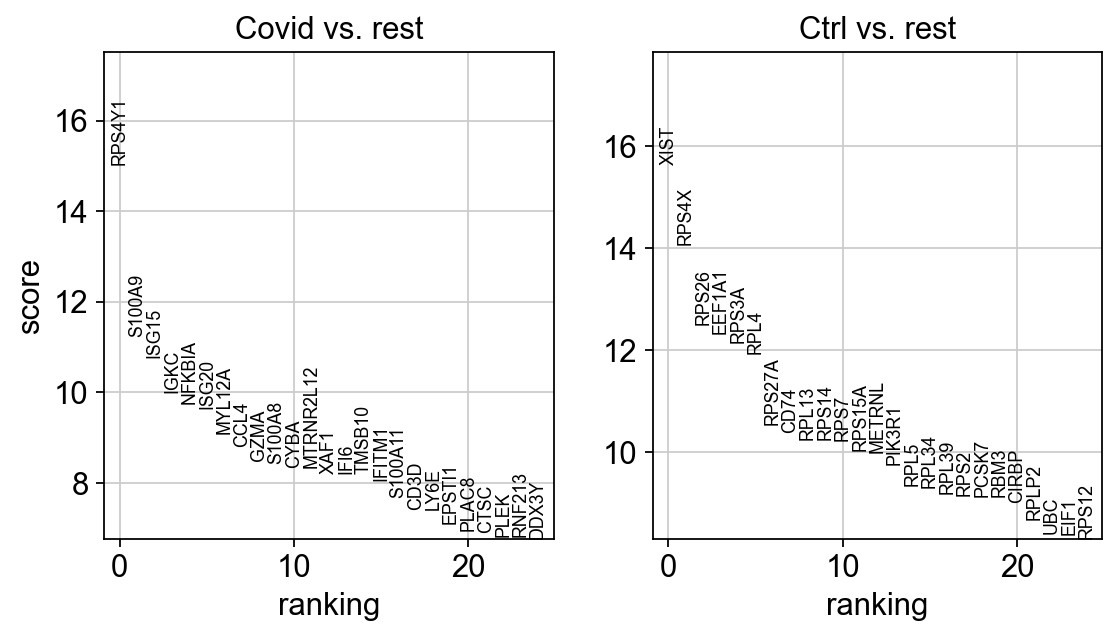

In [19]:
sc.tl.rank_genes_groups(cl1, 'type', method='wilcoxon', key_added = "wilcoxon")
sc.pl.rank_genes_groups(cl1, n_genes=25, sharey=False, key="wilcoxon")

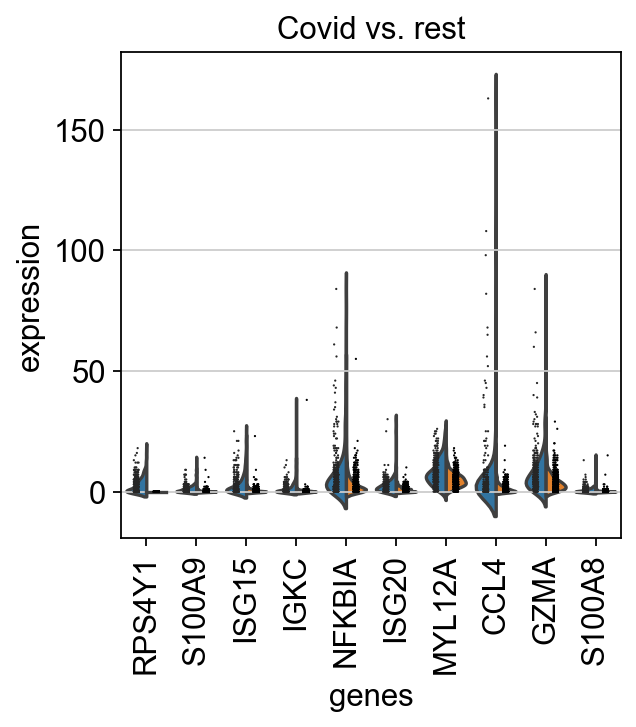

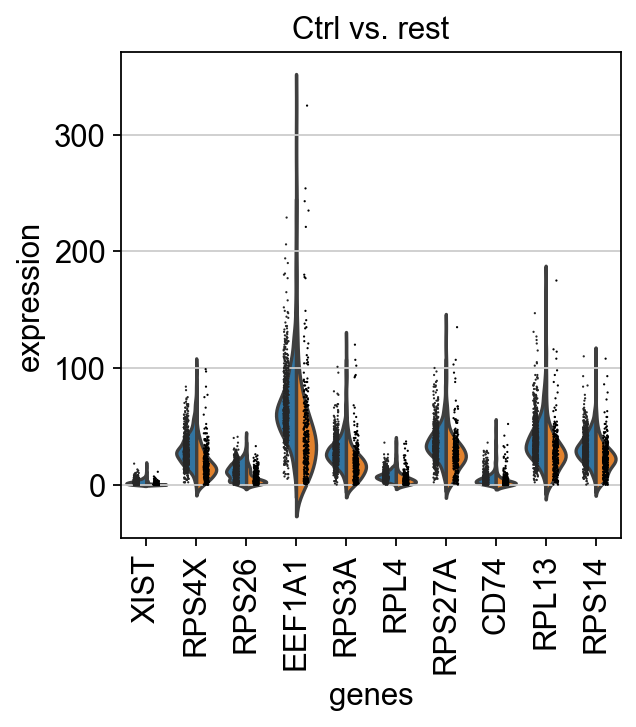

In [20]:
sc.pl.rank_genes_groups_violin(cl1, n_genes=10, key="wilcoxon")


We can also plot these genes across all clusters, but split by "type", to check if the genes are also up/downregulated in other celltypes.


In [21]:
import seaborn as sns

genes1 = sc.get.rank_genes_groups_df(cl1, group='Covid', key='wilcoxon')['names'][:5]
genes2 = sc.get.rank_genes_groups_df(cl1, group='Ctrl', key='wilcoxon')['names'][:5]
genes = genes1.tolist() +  genes2.tolist() 
df = sc.get.obs_df(adata, genes + ['louvain_0.6','type'], use_raw=True)
df2 = df.melt(id_vars=["louvain_0.6",'type'], value_vars=genes)



/Users/asbj/miniconda3/envs/scRNAseq2021/lib/python3.6/site-packages/seaborn/categorical.py:3704: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


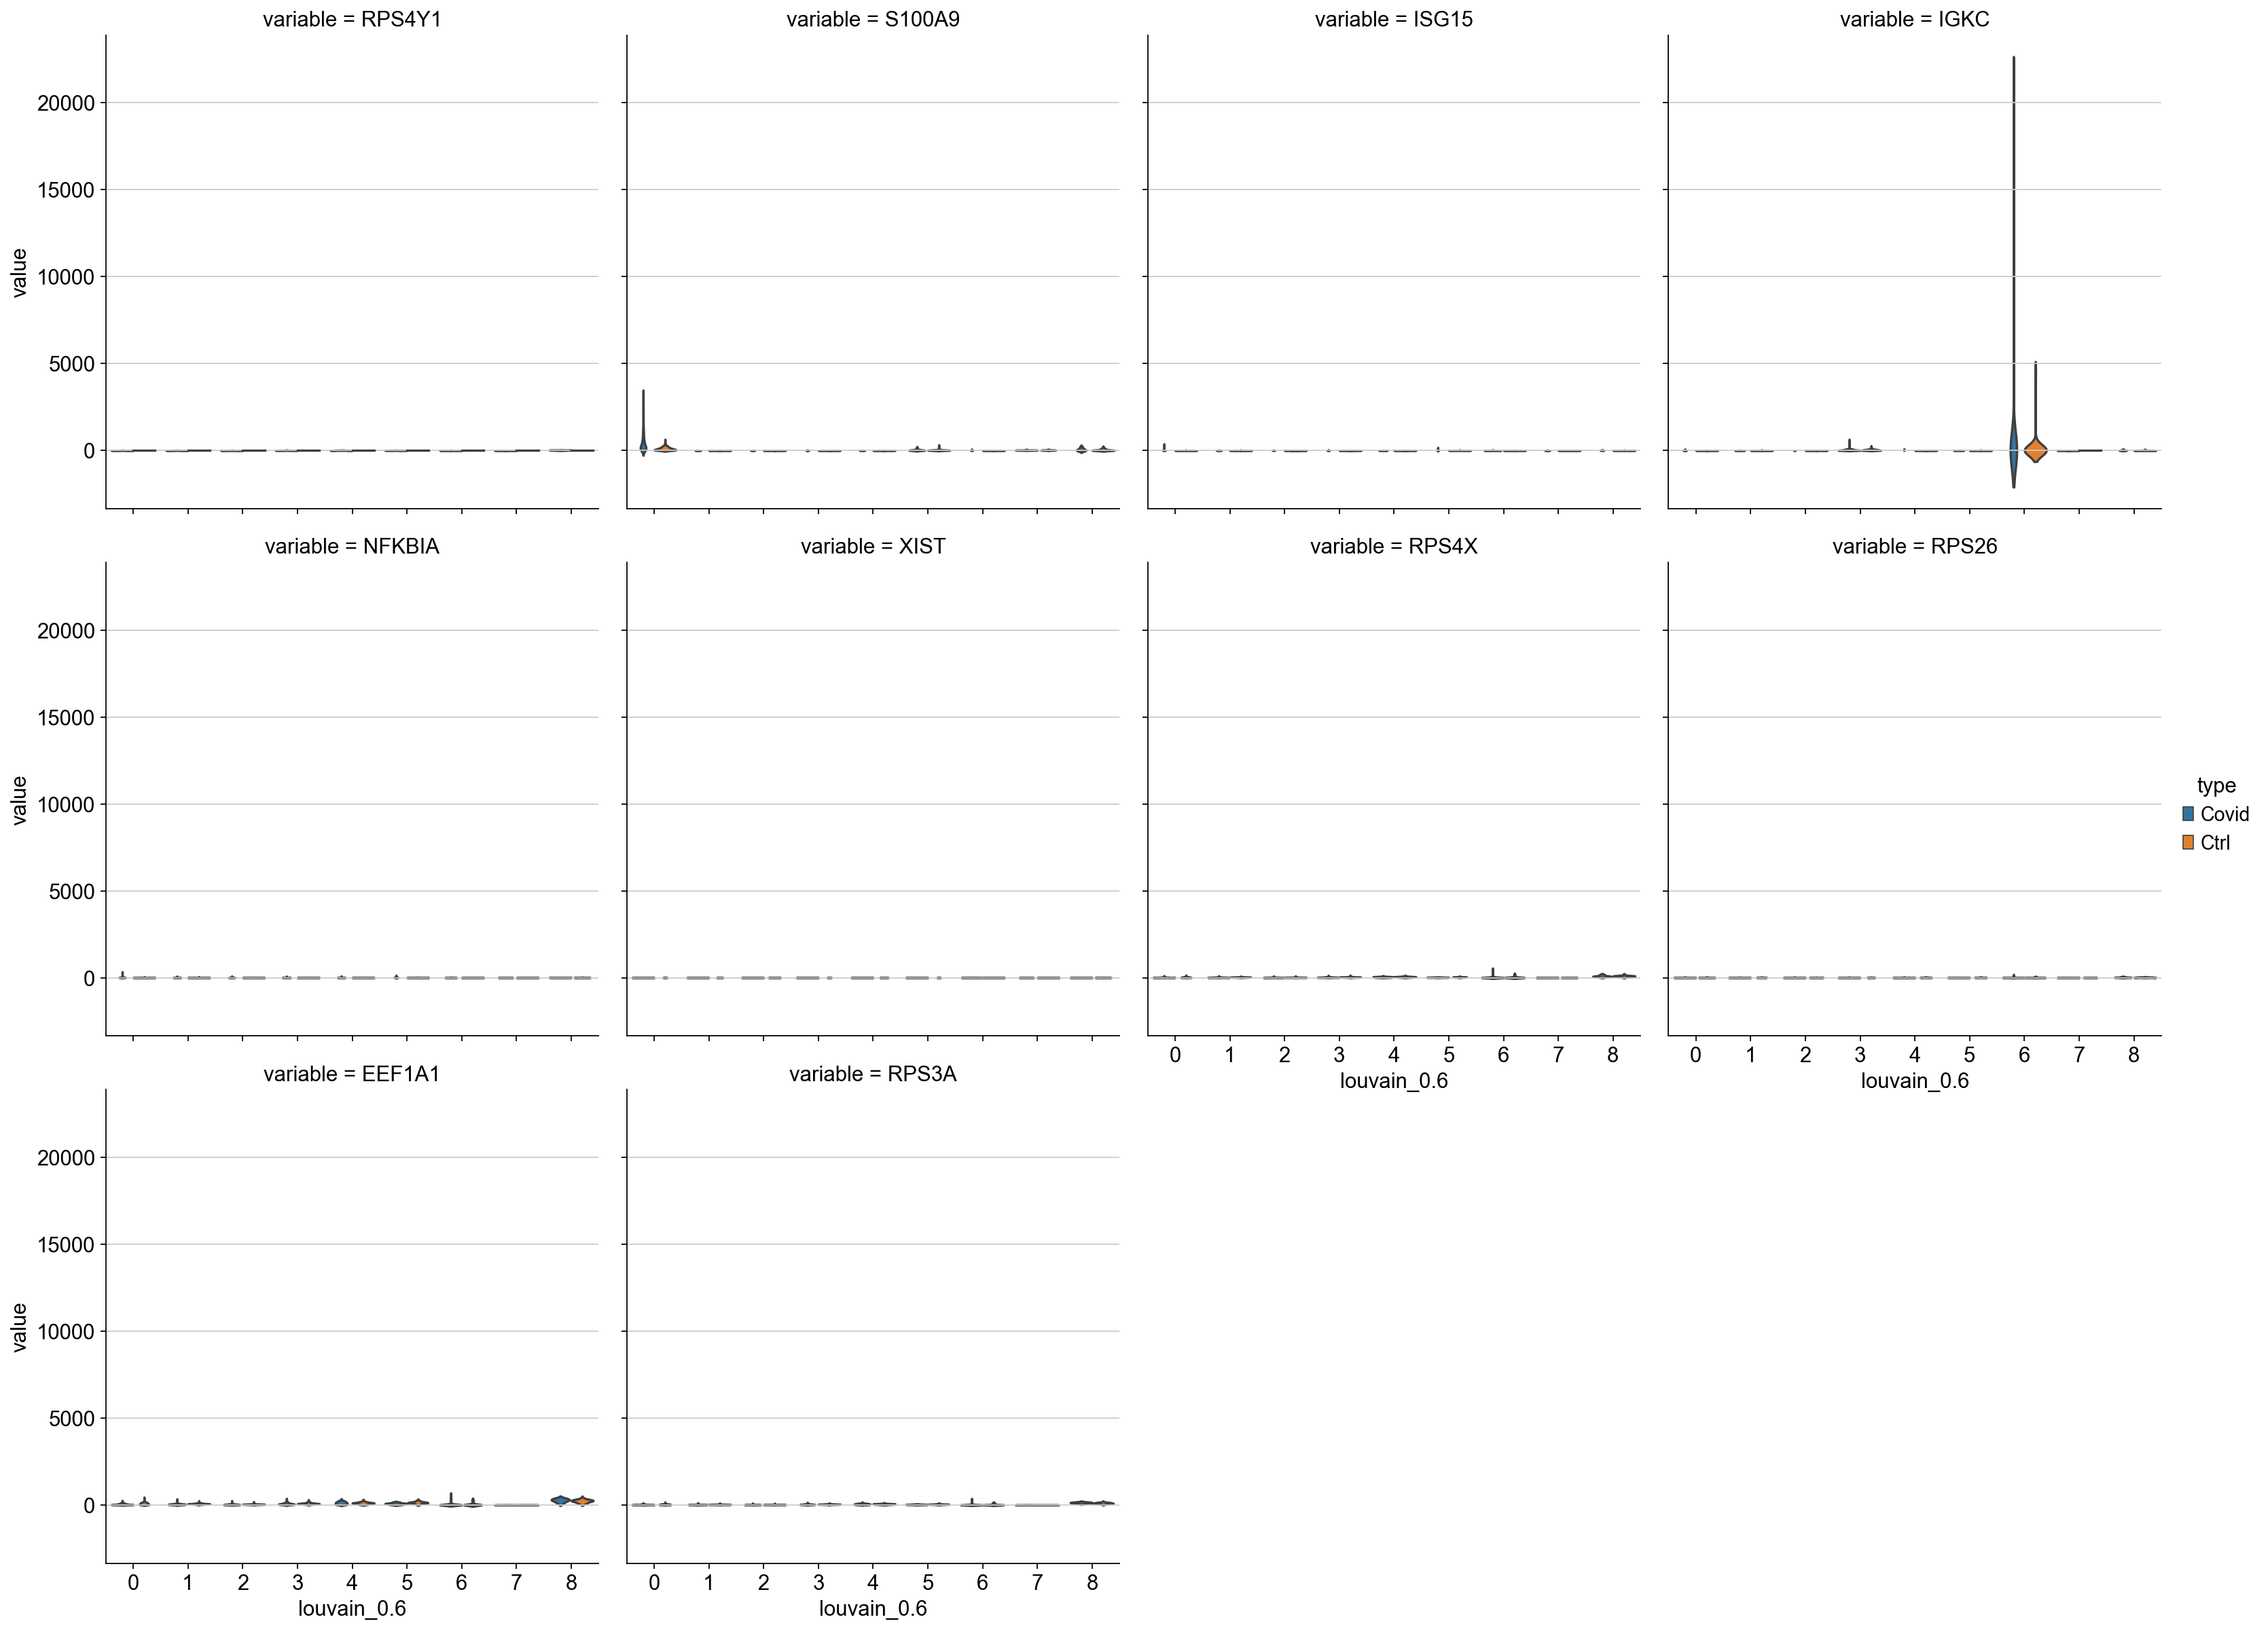

In [22]:
sns.factorplot(x = "louvain_0.6", y = "value", hue = "type", kind = 'violin', 
               col = "variable", data = df2, col_wrap=4, inner=None)
